In [ ]:
!pip install -q transformers torch accelerate bitsandbytes datasets

import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm


In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = tokenizer.eos_token_id

print("Loading model... (This takes a minute)")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Model loaded successfully!")

Loading model... (This takes a minute)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully!


In [ ]:
# Load Source Data (TriviaQA) - keeping it small for the test
print("Loading Source Data (TriviaQA)...")
# We use validation set, first 1000 examples for the test run
trivia_qa = load_dataset("trivia_qa", "rc.nocontext", split="validation[:1000]")

wack_data = []

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Generating WACK Dataset...")
for row in tqdm(trivia_qa):
    question = row['question']
    answer = row['answer']['value']

    # does the model get it right 3 times (reduced from 5 for speed in this test)?
    known = True
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    for _ in range(3):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.5,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simple string matching
        if answer.lower() not in gen_text.lower():
            known = False
            break

    if not known:
        continue # skip if model doesn't know (i.e. not factually correct or hallucinate)

    # apply Snowballing to Force Hallucination
    bad_context = """
    Q: What is the capital of France? A: Berlin
    Q: Who wrote Romeo and Juliet? A: Jane Austen
    """
    snowball_prompt = bad_context + f"\nQ: {question}\nA:"

    sb_inputs = tokenizer(snowball_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        sb_outputs = model.generate(
            **sb_inputs,
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id
        )
    sb_ans = tokenizer.decode(sb_outputs[0], skip_special_tokens=True)

    # 0 = Factually Correct
    # 1 = HK+ (Hallucinated despite knowing)
    label = "Factually Correct"

    # We strip the bad context from the answer check to be safe
    generated_only = sb_ans.replace(snowball_prompt, "")

    if answer.lower() not in generated_only.lower():
        label = "HK+"

    wack_data.append({
        "question": question,
        "prompt": snowball_prompt,
        "generated_answer": sb_ans,
        "label": label
    })

# Save the dataset
with open("wack_dataset.json", "w") as f:
    json.dump(wack_data, f)

print(f"Generated {len(wack_data)} WACK examples. Saved to 'wack_dataset.json'.")

Loading Source Data (TriviaQA)...


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Generating WACK Dataset...


100%|██████████| 1000/1000 [30:46<00:00,  1.85s/it]

Generated 484 WACK examples. Saved to 'wack_dataset.json'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Loading dataset...
Loaded 484 examples.
Extracting hidden states (this takes time)...


100%|██████████| 484/484 [02:02<00:00,  3.94it/s]


Extraction complete. Data shape: (484, 33, 4096)
Extraction complete. Data shape: (484, 33, 4096)
--- Balancing Dataset ---
Class 0 (Correct): 366, Class 1 (Hallucination): 118
Downsampling both to 118 samples (Total: 236)...
Training probes on each layer (Balanced Data)...


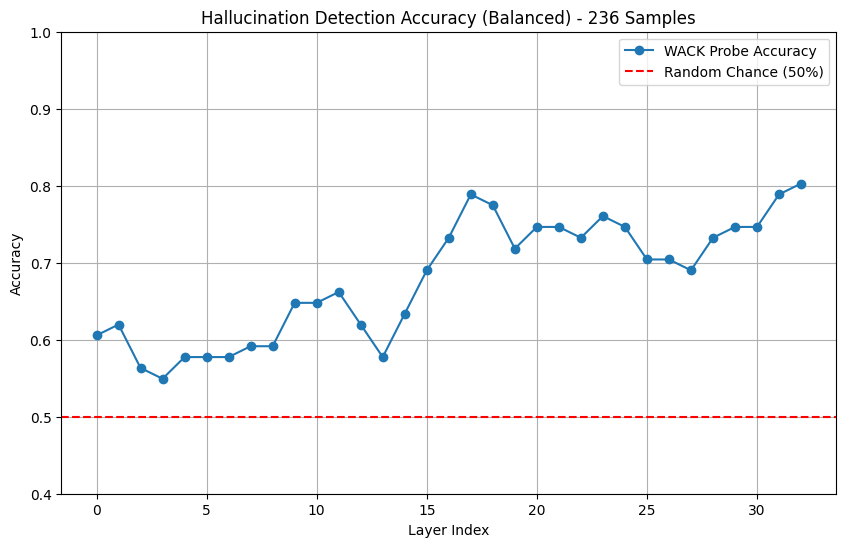

Peak Accuracy: 0.8028169014084507


In [ ]:
# load WACK dataset created in the previous step
print("Loading dataset...")
with open("wack_dataset.json", "r") as f:
    dataset = json.load(f)

if len(dataset) == 0:
    raise ValueError("Dataset is empty! Please run the generation step first.")

print(f"Loaded {len(dataset)} examples.")

# define Feature Extractor
def extract_hidden_states(model, tokenizer, text_input):

    inputs = tokenizer(text_input, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    extracted_layers = []
    for layer_tensor in outputs.hidden_states:
        vector = layer_tensor[0, -1, :].float().cpu().numpy()
        extracted_layers.append(vector)

    return np.array(extracted_layers)

# extract Features for the whole dataset
print("Extracting hidden states (this takes time)...")
X_all_layers = []
y_labels = []

for example in tqdm(dataset):
    # Construct the full text used for generation
    full_text = example['prompt'] + example['generated_answer']

    layers_data = extract_hidden_states(model, tokenizer, full_text)
    X_all_layers.append(layers_data)

    # 0 = Factually Correct
    # 1 = HK+ (Hallucinated despite knowing)
    if example['label'] == "Factually Correct":
        y_labels.append(0)
    else:
        y_labels.append(1)

X_all_layers = np.array(X_all_layers)
y_labels = np.array(y_labels)

print(f"Extraction complete. Data shape: {X_all_layers.shape}")

print("--- Balancing Dataset ---")
idx_0 = np.where(y_labels == 0)[0] # Factually Correct
idx_1 = np.where(y_labels == 1)[0] # Hallucination

min_len = min(len(idx_0), len(idx_1))
print(f"Class 0 (Correct): {len(idx_0)}, Class 1 (Hallucination): {len(idx_1)}")
print(f"Downsampling both to {min_len} samples (Total: {min_len*2})...")

idx_0_downsampled = np.random.choice(idx_0, min_len, replace=False)
idx_1_downsampled = np.random.choice(idx_1, min_len, replace=False)

balanced_indices = np.concatenate([idx_0_downsampled, idx_1_downsampled])
np.random.shuffle(balanced_indices)

X_balanced = X_all_layers[balanced_indices]
y_balanced = y_labels[balanced_indices]


# train Layer-wise Classifiers
accuracies = []
num_layers = X_balanced.shape[1]

# Split data (70% train, 30% test)
indices = np.arange(len(y_balanced))
train_idx, test_idx, y_train, y_test = train_test_split(
    indices, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print("Training probes on each layer (Balanced Data)...")
for layer_i in range(num_layers):
    X_layer = X_balanced[:, layer_i, :]

    X_train = X_layer[train_idx]
    X_test = X_layer[test_idx]

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    clf = LinearSVC(max_iter=1_000_000, tol=1e-5, random_state=42, dual="auto")
    clf.fit(X_train_norm, y_train)

    # Evaluate
    preds = clf.predict(X_test_norm)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

# 5. Visualize Results
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), accuracies, marker='o', label='WACK Probe Accuracy')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance (50%)') # Updated label
plt.title(f"Hallucination Detection Accuracy (Balanced) - {len(y_balanced)} Samples")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True)
plt.show()

print("Peak Accuracy:", max(accuracies))